# Network Visualization (TensorFlow)

In this notebook we will explore the use of *image gradients* for generating new images.

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a convolutional neural network model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image, then use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed, and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

In this notebook we will explore three techniques for image generation:

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.
3. **Class Visualization**: We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.

This notebook uses **TensorFlow**; we have provided another notebook which explores the same concepts in PyTorch. You only need to complete one of these two notebooks.

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from cs231n.classifiers.squeezenet import SqueezeNet
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import preprocess_image, deprocess_image
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

We have ported the PyTorch SqueezeNet model to TensorFlow; see: `cs231n/classifiers/squeezenet.py` for the model architecture.

To use SqueezeNet, you will need to first **download the weights** by changing into the `cs231n/datasets` directory and running `get_squeezenet_tf.sh`. Note that if you ran `get_assignment3_data.sh` then SqueezeNet will already be downloaded.

Once you've downloaded the Squeezenet model, we can load it into a new TensorFlow session:

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [3]:
tf.reset_default_graph()
sess = get_session()

SAVE_PATH = 'cs231n/datasets/squeezenet_tf'
if not os.path.exists(SAVE_PATH):
    raise ValueError("You need to download SqueezeNet!")
model = SqueezeNet(save_path=SAVE_PATH, sess=sess)

INFO:tensorflow:Restoring parameters from cs231n/datasets/squeezenet_tf\squeezenet.ckpt


## Load some ImageNet images
We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. To download these images, change to `cs231n/datasets/` and run `get_imagenet_val.sh`.

Since they come from the validation set, our pretrained model did not see these images during training.

Run the following cell to visualize some of these images, along with their ground-truth labels.

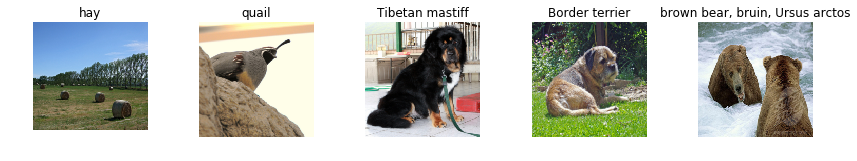

In [4]:
from cs231n.data_utils import load_imagenet_val
X_raw, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_raw[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## Preprocess images
The input to the pretrained model is expected to be normalized, so we first preprocess the images by subtracting the pixelwise mean and dividing by the pixelwise standard deviation.

In [5]:
X = np.array([preprocess_image(img) for img in X_raw])

# Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(H, W, 3)` then this gradient will also have shape `(H, W, 3)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

You will need to use the `model.classifier` Tensor containing the scores for each input, and will need to feed in values for the `model.image` and `model.labels` placeholder when evaluating the gradient. Open the file `cs231n/classifiers/squeezenet.py` and read the documentation to make sure you understand how to use the model. For example usage, you can see the `loss` attribute. 

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

In [6]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images, numpy array of shape (N, H, W, 3)
    - y: Labels for X, numpy of shape (N,)
    - model: A SqueezeNet model that will be used to compute the saliency map.

    Returns:
    - saliency: A numpy array of shape (N, H, W) giving the saliency maps for the
    input images.
    """
    saliency = None
    # Compute the score of the correct class for each example.
    # This gives a Tensor with shape [N], the number of examples.
    #
    # Note: this is equivalent to scores[np.arange(N), y] we used in NumPy
    # for computing vectorized losses.
    correct_scores = tf.gather_nd(model.classifier,
                                  tf.stack((tf.range(X.shape[0]), model.labels), axis=1))
    ###############################################################################
    # TODO: Implement this function. You should use the correct_scores to compute #
    # the loss, and tf.gradients to compute the gradient of the loss with respect #
    # to the input image stored in model.image.                                   #
    # Use the global sess variable to finally run the computation.                #
    # Note: model.image and model.labels are placeholders and must be fed values  #
    # when you call sess.run().                                                   #
    ###############################################################################
    cost = tf.reduce_sum(correct_scores)
    gradient = tf.reduce_max( tf.abs( tf.gradients(cost,model.image))[0],axis=3)  # cost에 대한 gradient == correct_scores에 대한 gradient
    saliency=sess.run(gradient,feed_dict={model.image: X, model.labels: y})
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

Once you have completed the implementation in the cell above, run the following to visualize some class saliency maps on our example images from the ImageNet validation set:

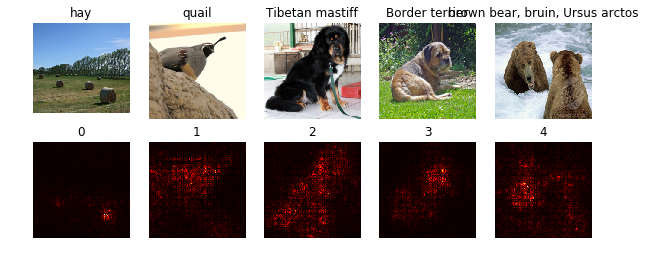

In [7]:
def show_saliency_maps(X, y, mask):
    mask = np.asarray(mask)
    Xm = X[mask]
    ym = y[mask]

    saliency = compute_saliency_maps(Xm, ym, model)

    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(Xm[i]))
        plt.axis('off')
        plt.title(class_names[ym[i]])
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
    plt.show()

mask = np.arange(5)
show_saliency_maps(X, y, mask)

# Fooling Images
We can also use image gradients to generate "fooling images" as discussed in [3]. Given an image and a target class, we can perform gradient **ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [8]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image, of shape (1, 224, 224, 3)
    - target_y: An integer in the range [0, 1000)
    - model: Pretrained SqueezeNet model

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    X_fooling = X.copy()
    learning_rate = 1
    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. Use gradient ascent on the target class score, using   #
    # the model.classifier Tensor to get the class scores for the model.image.   #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    # You should write a training loop                                           #
    #                                                                            #  
    # HINT: For most examples, you should be able to generate a fooling image    #
    # in fewer than 100 iterations of gradient ascent.                           #
    # You can print your progress over iterations to check your algorithm.       #
    ##############################################################################
    scores = model.classifier[0,target_y]
    gradient = tf.gradients(scores,model.image)[0]
    gradient = gradient / tf.norm(gradient)
    for i in range(100):
        gradient_,classification_ = sess.run([gradient,model.classifier[0]], feed_dict={model.image: X_fooling})
        if np.argmax(classification_) == target_y:
            break
        X_fooling += learning_rate * gradient_
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling

Run the following to generate a fooling image. Feel free to change the `idx` variable to explore other images.

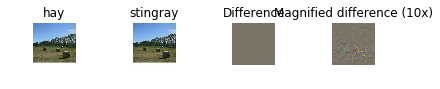

In [9]:
idx = 0
Xi = X[idx][None]
target_y = 6
X_fooling = make_fooling_image(Xi, target_y, model)

# Make sure that X_fooling is classified as y_target
scores = sess.run(model.classifier, {model.image: X_fooling})
assert scores[0].argmax() == target_y, 'The network is not fooled!'

# Show original image, fooling image, and difference
orig_img = deprocess_image(Xi[0])
fool_img = deprocess_image(X_fooling[0])
# Rescale 
plt.subplot(1, 4, 1)
plt.imshow(orig_img)
plt.axis('off')
plt.title(class_names[y[idx]])
plt.subplot(1, 4, 2)
plt.imshow(fool_img)
plt.title(class_names[target_y])
plt.axis('off')
plt.subplot(1, 4, 3)
plt.title('Difference')
plt.imshow(deprocess_image((Xi-X_fooling)[0]))
plt.axis('off')
plt.subplot(1, 4, 4)
plt.title('Magnified difference (10x)')
plt.imshow(deprocess_image(10 * (Xi-X_fooling)[0]))
plt.axis('off')
plt.gcf().tight_layout()

# Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [2]; [3] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I s_y(I) - R(I)
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [3] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [10]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    return X

In [11]:
def create_class_visualization(target_y, model, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    X = 255 * np.random.rand(224, 224, 3)
    X = preprocess_image(X)[None]
    
    ########################################################################
    # TODO: Compute the loss and the gradient of the loss with respect to  #
    # the input image, model.image. We compute these outside the loop so   #
    # that we don't have to recompute the gradient graph at each iteration #
    #                                                                      #
    # Note: loss and grad should be TensorFlow Tensors, not numpy arrays!  #
    #                                                                      #
    # The loss is the score for the target label, target_y. You should     #
    # use model.classifier to get the scores, and tf.gradients to compute  #
    # gradients. Don't forget the (subtracted) L2 regularization term!     #
    ########################################################################
    loss = model.classifier[0,target_y] # scalar loss
    grad = tf.gradients(loss,model.image)[0] # gradient of loss with respect to model.image, same size as model.image
    pass
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)
        
        ########################################################################
        # TODO: Use sess to compute the value of the gradient of the score for #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. You should use   #
        # the grad variable you defined above.                                 #
        #                                                                      #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        gradient_ = sess.run(grad, feed_dict={model.image: X})
        X += (learning_rate * gradient_ - 2*l2_reg*X)
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        X = np.clip(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess_image(X[0]))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
    return X

Once you have completed the implementation in the cell above, run the following cell to generate an image of Tarantula:

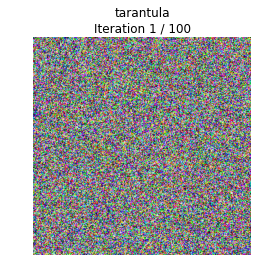

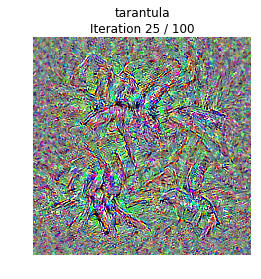

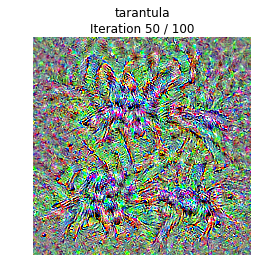

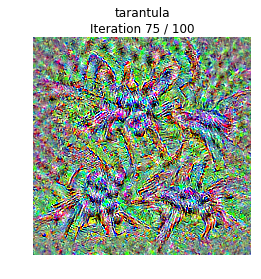

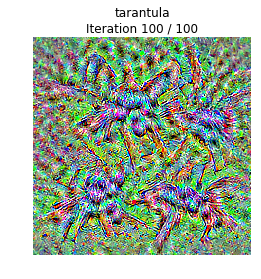

In [12]:
target_y = 76 # Tarantula
out = create_class_visualization(target_y, model)

Try out your class visualization on other classes! You should also feel free to play with various hyperparameters to try and improve the quality of the generated image, but this is not required.

groom, bridegroom


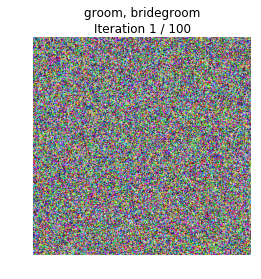

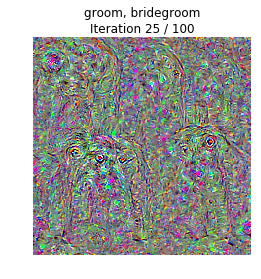

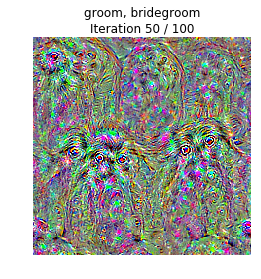

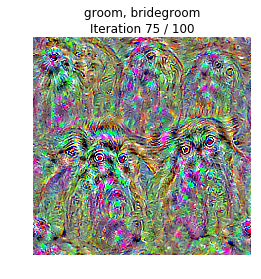

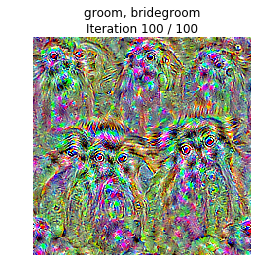

In [15]:
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
target_y = np.random.randint(1000)
print(class_names[target_y])
X = create_class_visualization(target_y, model)